In [4]:
import math
import numpy as np
import sys
import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [5]:
input_filename = "data/LAMP_80s_240mpp_ratio_albed_01.img"
shape = (2501, 2501) # matrix size
dtype = np.float32 # big-endian unsigned integer (16bit)
output_filename = "LAMP_BRITE.PNG"

In [6]:
height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16),
                    (7624,7624))
albedo = np.reshape(np.fromfile(open("data/LDAM_50S_1000M_FLOAT.IMG",
                                     'rb'), np.float32),
                    (2532,2532))
LAMP_ratio_albed = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_albed_01.img",
                                     'rb'), np.float32),
                    (2501,2501))
LAMP_ratio_brite = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_brite_01.img",
                                     'rb'), np.float32),
                    (2501,2501))

In [7]:
height = height[1311:-1311,1311:-1311]
albedo = albedo[966:-966,966:-966]

lamp_brite = cv2.resize(LAMP_ratio_brite, dsize=height.shape)
lamp_albed = cv2.resize(LAMP_ratio_albed, dsize=height.shape)
albedo = cv2.resize(albedo, dsize=height.shape)

In [8]:
threshold_albedo = 0.35
threshold_lamp_ratio = 1.2

In [9]:
image = albedo > threshold_albedo

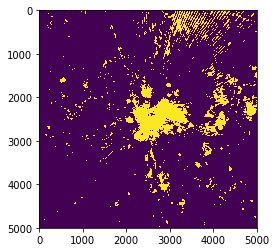

In [10]:
plt.imshow(image)
#plt.savefig(output_filename)
plt.show()

In [11]:
POI = ((lamp_albed > threshold_lamp_ratio) & 
        (lamp_brite > threshold_lamp_ratio) & 
        (albedo > threshold_albedo))

/Users/gschardong/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [12]:
km_per_px = 0.12
rover_max_dist_km = 24
rover_max_dist_px = rover_max_dist_km / km_per_px
kern_size = int(rover_max_dist_px)

In [13]:
def create_disc_kernel(size):
    half_size = int(size // 2)
    y, x = np.ogrid[-half_size:half_size, -half_size:half_size]
    mask = x ** 2 + y ** 2 <= half_size ** 2
    kernel = np.zeros((size, size))
    kernel[mask] = 1
    return kernel

In [18]:
from multiprocessing import Pool
from scipy.ndimage.filters import generic_filter as gf


sq_kern = kern_size * kern_size
disc = create_disc_kernel(kern_size)


def process_roi_round(params_tup):
    i, j = params_tup
    half_k = disc.shape[0] // 2
    ROI = POI[(i-half_k):(i+half_k), (j-half_k):(j+half_k)]
    count = (ROI * disc).sum()
    prob = count / sq_kern
    return count, prob, i, j

In [19]:
from itertools import product

step = 1
x = (POI.shape[0] - kern_size) // step
y = (POI.shape[1] - kern_size) // step
params = product(np.arange(kern_size, x), np.arange(kern_size, y))
POI_prob = np.zeros((x, y))
POI_count = np.zeros((x, y))

In [20]:
%%time
with Pool(processes=4) as p:
    results = p.map_async(process_roi_round, params).get()
    for r in results:
        count, prob, i, j = r
        POI_prob[i, j] = prob
        POI_count[i, j] = count

In [23]:
np.save('POI_prob_round.npy', POI_prob)
np.save('POI_count_round.npy', POI_count)

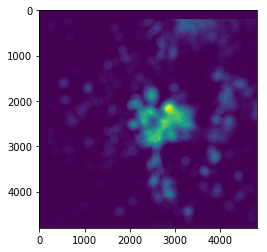

<Figure size 432x288 with 0 Axes>

In [26]:
plt.imshow(POI_count)
plt.show()
plt.savefig('POI_count_roundkern.png')

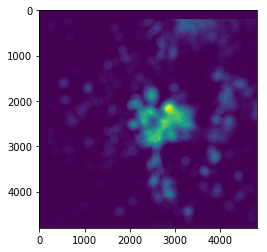

<Figure size 432x288 with 0 Axes>

In [27]:
plt.imshow(POI_prob)
plt.show()
plt.savefig('POI_prob_roundkern.png')